# 18.065 project: comparison result

In [1]:
#import sys
#!{sys.executable} -m pip install tf-nightly

In [1]:
import sklearn
import numpy as np
from sklearn.datasets import load_iris,make_swiss_roll,fetch_lfw_people
from  sklearn.model_selection import train_test_split
# Custom train/test wrappers for sklearn models
from sklearn_wrappers import *
import pickle
import matplotlib.pyplot as plt
import kernel_pca as kpca

In [3]:
# more readable visuals 
#large = 22; med = 16; small = 10
#params = {'axes.titlesize': large,
#          'legend.fontsize': med,
#          'figure.figsize': (16, 10),
#          'axes.labelsize': med,
#          'axes.titlesize': med,
#          'axes.linewidth': 2,
#          'xtick.labelsize': med,
#          'ytick.labelsize': med,
#          'figure.titlesize': large}
#plt.style.use('seaborn-white')
#plt.rcParams.update(params)
#%matplotlib inline

## Test sweep code

In [3]:
def run_test_sweep(num_dataset_dims, X_train, X_test, is_faces, dataset_name, fn_prefix="results_", h=None, w=None, skip_spca_for_faces=False, no_sigmoid=False, show_eigen_faces=False):
    
    # h and w must be specified if this is a faces dataset
    assert(not (is_faces and (h is None or w is None)))        
    
    res={}
    k_iters=[]
    model_iters=[]
    data_iters=[]
    hparam_iters=[]
    loss_iters=[]
    
    k_vals=[]
    
    if num_dataset_dims<10:
        k_vals=range(1,num_dataset_dims+1)
    else:
        #k_vals=[1,2,3,4,5,6,7,8]
        k_vals=np.linspace(start=1, stop=num_dataset_dims, num=8)
    
    for k_prim in k_vals:
        k=int(k_prim)
        print("Number of components: k =",k)

        # Standard PCA
        _, pca_err = pca_exp(X_train, X_test, k)
        k_iters.append(k)
        model_iters.append("pca")
        data_iters.append(dataset_name)
        hparam_iters.append({"pca":None})
        loss_iters.append(pca_err)
        
        # SPCA
        best_spca_alpha=[]
        best_spca_alpha_err=[]
        if is_faces:
            if skip_spca_for_faces:
                best_spca_alpha=None
                best_spca_alpha_err=0.0
            else:
                best_spca_alpha, best_spca_alpha_err, best_eigenfaces_spca = spca_exp_faces(X_train,X_test,k,h,w)                
        else:
            best_spca_alpha, best_spca_alpha_err = spca_exp(X_train,X_test,k)
        k_iters.append(k)
        model_iters.append("spca")
        data_iters.append(dataset_name)
        hparam_iters.append({"alpha":best_spca_alpha})
        loss_iters.append(best_spca_alpha_err)
        
        # KPCA
        best_kernel, best_kernel_err = kernel_exp(X_train,X_test,k,no_sigmoid=no_sigmoid)
        k_iters.append(k)
        model_iters.append("kpca")
        data_iters.append(dataset_name)
        hparam_iters.append({"kernel":best_kernel})
        loss_iters.append(best_kernel_err)

        # Own KPCA implementation     
        _, own_kernel_err = kpca.kernel_PCA(X_train, X_test, n_components=k, kernel='rbf', gamma=0.0433, mode='recon', alpha=1.0)
        k_iters.append(k)
        model_iters.append("own kpca")
        data_iters.append(dataset_name)
        hparam_iters.append({"kernel":'rbf'})
        loss_iters.append(own_kernel_err) 
        
        # Autoencoder
        _, best_autoencoder_err = autoencoder_exp(X_train, X_test, k)
        k_iters.append(k)
        model_iters.append("autoencoder")
        data_iters.append(dataset_name)
        hparam_iters.append({})
        loss_iters.append(best_autoencoder_err)                
        
        # NMF
        best_nmf_err=[]
        if is_faces:
            _, best_nmf_err, eigenfaces_nmf = nmf_exp_faces(X_train,X_test,k,h,w)
        else:
            _, best_nmf_err = nmf_exp(X_train,X_test,k)
        k_iters.append(k)
        model_iters.append("nmf")
        data_iters.append(dataset_name)
        hparam_iters.append({})
        loss_iters.append(best_nmf_err)              
        
        # ==> Summary
        print("- MSE loss summary: ",dataset_name,"is_faces =",is_faces,"k =",k)
        print("-- Standard PCA: err=",pca_err)
        print("-- Sparse PCA (alpha=",best_spca_alpha,"): err=",best_spca_alpha_err)
        print("-- Kernel PCA(",best_kernel,"): err=",best_kernel_err)
        print("-- Own Kernel PCA: err=",own_kernel_err)
        print("-- Autoencoder: err=",best_autoencoder_err)
        print("-- NMF: err=",best_nmf_err)

        if is_faces:
            if show_eigen_faces:
                if not skip_spca_for_faces:
                    eigenface_titles_spca = [f"SPCA eigenface {i}" for i in range(best_eigenfaces_spca.shape[0])]
                    plot_gallery(best_eigenfaces_spca, eigenface_titles_spca, k, h, w)
                    plt.show()
                eigenface_titles_nmf = [f"NMF eigenface {i}" for i in range(eigenfaces_nmf.shape[0])]
                plot_gallery(eigenfaces_nmf, eigenface_titles_nmf, k, h, w)
                plt.show()
        
        
    res["k_iters"]=k_iters
    res["model_iters"]=model_iters
    res["data_iters"]=data_iters
    res["hparam_iters"]=hparam_iters
    res["loss_iters"]=loss_iters
    
    fn=fn_prefix+dataset_name+".p"
    print("\n\nSaving results to",fn,"...")    
    with open(fn,"wb") as fp:
        pickle.dump(res, fp)
    print("- Done.")
    
    return res

In [4]:
def res_query(res,model=None):
    k_iters=[]
    loss_iters=[]
    
    for idx in range(len(res["k_iters"])):
        if res["model_iters"][idx]==model:
            k_iters.append(res["k_iters"][idx])
            loss_iters.append(res["loss_iters"][idx])
    
    return k_iters,loss_iters

## Iris dataset: Sparse PCA, Kernel PCA, autoencoder, NMF (TODO); MSE, Frobenius (TODO)

In [5]:
# load Iris dataset
iris = load_iris()
X = iris.data # predictor
y = iris.target #response
num_dataset_dims=4
dataset_name="iris"
print('The predictor variable shape: ', X.shape)
print('The response variable shape: ', y.shape)
print('The number of dataset dimensions: ',num_dataset_dims)

# Standardize the data
#scaler = MinMaxScaler()
#X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

The predictor variable shape:  (150, 4)
The response variable shape:  (150,)
The number of dataset dimensions:  4


Number of components: k = 1

Standard PCA err: 0.08445121414129521
alpha= 0.001 err= 0.08444980228677235
alpha= 0.002 err= 0.08444839106270499
alpha= 0.005 err= 0.08444416117840108
alpha= 0.01 err= 0.08443683382672178
alpha= 0.02 err= 0.0844225264789661
alpha= 0.05 err= 0.0843796398540697
alpha= 0.1 err= 0.08430980337873431
alpha= 0.2 err= 0.08417665024787134
alpha= 0.5 err= 0.08383649597563904
alpha= 1.0 err= 0.08353270703825291
alpha= 2.0 err= 0.08473597418229319
alpha= 5.0 err= 0.0956584590029828


Best SPCA:
- alpha: 1.0
- err: 0.08353270703825291
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.2146923259213807
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 1.0162541892445827


Best MSE reconstruction error: 0.2146923259213807
- Kernel: RBF kernel, $\gamma=0.04$


 Own rbf kpca implementation
rbf kernel, mse err = 0.21469232592138077
Model: "model"
_________________________________________________________________


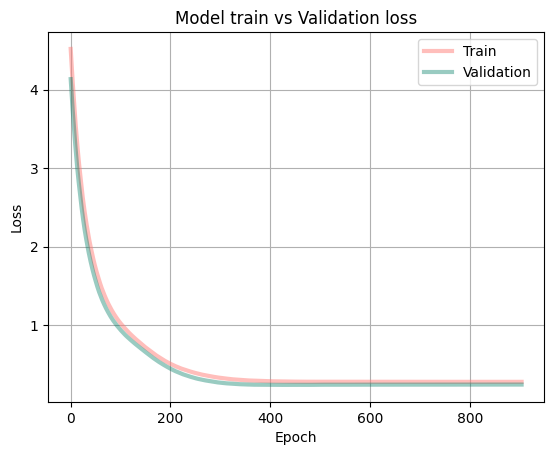

Training loss: 0.2741101384162903
Validation loss: 0.23945097625255585
MSE on training data: 0.10007460674661292
MSE on test data: 0.08548909222215527


Best NMF:
Basis vectors:
 [[1.18558032 0.913377   1.33057414 1.32708452]]
Coefficients:
 [[0.22385812]
 [0.12539011]
 [0.09026505]
 [0.23582576]
 [0.35726372]
 [0.4758492 ]
 [0.38173096]
 [0.16974067]
 [0.40543153]
 [0.21020557]
 [0.23487284]
 [0.3162771 ]
 [0.16888551]
 [0.51891248]
 [0.18444978]
 [0.35009302]
 [0.44708433]
 [0.45458983]
 [0.42309497]
 [0.55352549]
 [0.73663061]
 [0.30336664]
 [0.20937183]
 [0.4839197 ]
 [0.65152678]
 [0.4725299 ]
 [0.67001248]
 [0.34777196]
 [0.41168263]
 [0.62192153]
 [0.46441434]
 [0.60050471]
 [0.46844377]
 [0.09295176]
 [0.17066163]
 [0.4006249 ]
 [0.54394471]
 [0.23671382]
 [0.44622985]
 [0.60958824]
 [0.67489571]
 [0.2282554 ]
 [0.15387588]
 [0.39960412]
 [0.1920204 ]
 [0.50742092]
 [0.71715883]
 [0.20398804]
 [0.24509658]
 [0.57605032]
 [0.32045156]
 [0.66468233]
 [0.33538323]
 [0.28642769]
 [

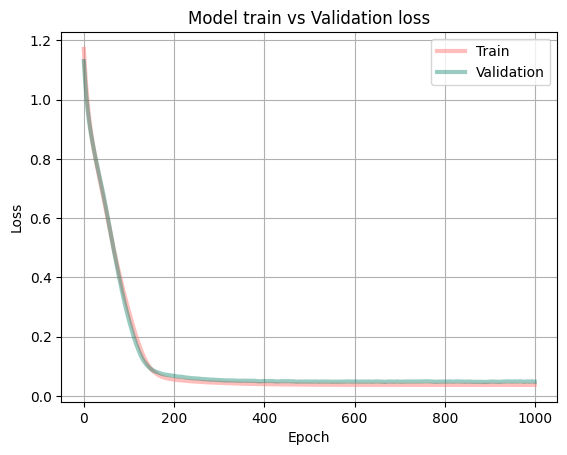

Training loss: 0.03699493780732155
Validation loss: 0.047833796590566635
MSE on training data: 0.03248287920105294
MSE on test data: 0.04086710771981836


Best NMF:
Basis vectors:
 [[0.82137556 0.07780183 1.12032218 1.12846419]
 [0.19895453 0.74626487 0.01140546 0.        ]]
Coefficients:
 [[0.32952816 0.        ]
 [0.05031346 0.55845463]
 [0.02007459 0.47188552]
 [0.31304371 0.10555654]
 [0.47906655 0.1391285 ]
 [0.63230103 0.21018511]
 [0.51114443 0.15163881]
 [0.05156322 0.82758345]
 [0.48662464 0.40440473]
 [0.11501969 0.80358848]
 [0.06900751 1.15520398]
 [0.39851746 0.23373983]
 [0.05867103 0.79150772]
 [0.6720403  0.30494954]
 [0.08772853 0.76219068]
 [0.39897164 0.4411315 ]
 [0.56748801 0.3124831 ]
 [0.52595217 0.53856113]
 [0.49443137 0.47997093]
 [0.71194891 0.34646522]
 [0.83601404 0.94303425]
 [0.36290806 0.30785597]
 [0.02950674 1.1682566 ]
 [0.58351126 0.47120368]
 [0.83462634 0.42222331]
 [0.58982349 0.37339079]
 [0.83771901 0.52333305]
 [0.43003827 0.29233003]
 [0.48118

c:\Users\Jasmine\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


alpha= 0.001 err= 0.013684763344123795
alpha= 0.002 err= 0.013686208689456749
alpha= 0.005 err= 0.013670331320001198
alpha= 0.01 err= 0.013639326236472654
alpha= 0.02 err= 0.013673172866323356
alpha= 0.05 err= 0.013716171883684227
alpha= 0.1 err= 0.01377739251482688
alpha= 0.2 err= 0.013968265303509642
alpha= 0.5 err= 0.015200882744925604
alpha= 1.0 err= 0.01815494845348449
alpha= 2.0 err= 0.018561923682957976
alpha= 5.0 err= 0.018736824767198453


Best SPCA:
- alpha: 0.01
- err: 0.013639326236472654
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.19038382772938334
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 1.0162525503980575


Best MSE reconstruction error: 0.19038382772938334
- Kernel: RBF kernel, $\gamma=0.04$


 Own rbf kpca implementation
rbf kernel, mse err = 0.1903838277293832
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape        

KeyboardInterrupt: 

In [6]:
# Run Iris test sweep
res=run_test_sweep(num_dataset_dims, X_train, X_test, is_faces=False, dataset_name=dataset_name)

Filename: results_iris.p


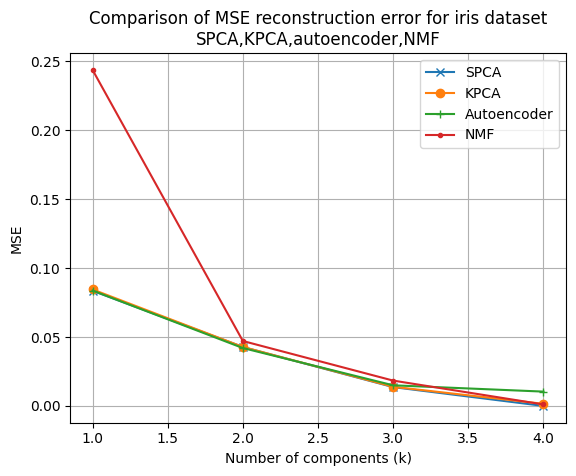

In [8]:
# Reload the test data which was just saved
fn_prefix="results_"
fn=fn_prefix+dataset_name+".p"
print("Filename:",fn)
res_loaded={}
with open(fn,"rb") as fp:
    res_loaded = pickle.load(fp)

k_spca,loss_spca=res_query(res_loaded,model="spca")
k_kpca,loss_kpca=res_query(res_loaded,model="kpca")
k_autoencoder,loss_autoencoder=res_query(res_loaded,model="autoencoder")
k_nmf,loss_nmf=res_query(res_loaded,model="nmf")

# Plot comparison
plt.plot(k_spca,loss_spca,"x-")
plt.plot(k_kpca,loss_kpca,"o-")
plt.plot(k_autoencoder,loss_autoencoder,"+-")
plt.plot(k_nmf,loss_nmf,".-")
plt.grid('on')
plt.xlabel('Number of components (k)')
plt.ylabel('MSE')
plt.title('Comparison of MSE reconstruction error for '+dataset_name+' dataset\nSPCA,KPCA,autoencoder,NMF')
plt.legend(["SPCA","KPCA","Autoencoder","NMF"])

## Swiss roll dataset: Sparse PCA, Kernel PCA, autoencoder

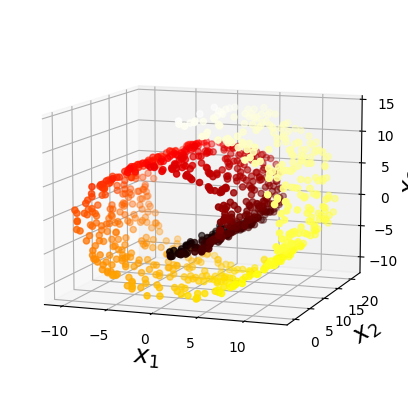

In [7]:
# Drawing on inspiration from https://docs.google.com/document/d/1lmaQowAhgf1OLbnSjl3X20j1idh-BdaQPZTrJslSJc0/edit "Kernel PCA" section

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
num_dataset_dims=3
dataset_name='swiss'
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

X_train, X_test, y_train, y_test = train_test_split(X, t, random_state=0)

In [8]:
# Run Swiss roll test sweep
res=run_test_sweep(num_dataset_dims, X_train, X_test, is_faces=False, dataset_name=dataset_name)

Number of components: k = 1

Standard PCA err: 25.887407044922004
alpha= 0.001 err= 25.887351999528935
alpha= 0.002 err= 25.887296954852243
alpha= 0.005 err= 25.88713182515069
alpha= 0.01 err= 25.886324989399625
alpha= 0.02 err= 25.8844599380465
alpha= 0.05 err= 25.878897851663936
alpha= 0.1 err= 25.869402574519928
alpha= 0.2 err= 25.850513159107535
alpha= 0.5 err= 25.795168597984954
alpha= 1.0 err= 25.732112171148724
alpha= 2.0 err= 25.844414308383772
alpha= 5.0 err= 25.848517330639865


Best SPCA:
- alpha: 1.0
- err: 25.732112171148724
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 26.488551619123683
- New best kernel
Kernel PCA ( Sigmoid kernel, $\gamma=10^{-3}, r=1$ ) MSE reconstruction loss: 43.12945208110352


Best MSE reconstruction error: 26.488551619123683
- Kernel: RBF kernel, $\gamma=0.04$


 Own rbf kpca implementation
rbf kernel, mse err = 26.488551619123665
Model: "model_3"
_________________________________________________________________
 Layer (type) 

KeyboardInterrupt: 

Filename: results_swiss.p


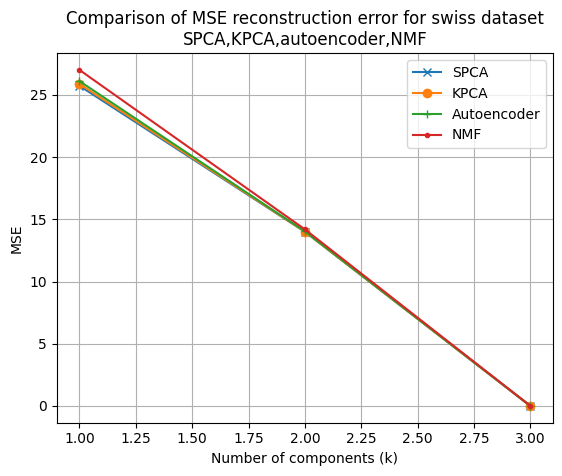

In [11]:
# Reload the test data which was just saved
fn_prefix="results_"
fn=fn_prefix+dataset_name+".p"
print("Filename:",fn)
res_loaded={}
with open(fn,"rb") as fp:
    res_loaded = pickle.load(fp)

k_spca,loss_spca=res_query(res_loaded,model="spca")
k_kpca,loss_kpca=res_query(res_loaded,model="kpca")
k_autoencoder,loss_autoencoder=res_query(res_loaded,model="autoencoder")
k_nmf,loss_nmf=res_query(res_loaded,model="nmf")

# Plot comparison
plt.plot(k_spca,loss_spca,"x-")
plt.plot(k_kpca,loss_kpca,"o-")
plt.plot(k_autoencoder,loss_autoencoder,"+-")
plt.plot(k_nmf,loss_nmf,".-")
plt.grid('on')
plt.xlabel('Number of components (k)')
plt.ylabel('MSE')
plt.title('Comparison of MSE reconstruction error for '+dataset_name+' dataset\nSPCA,KPCA,autoencoder,NMF')
plt.legend(["SPCA","KPCA","Autoencoder","NMF"])

## LFW dataset: Sparse PCA, Kernel PCA, autoencoder

In [9]:
# Takes 6 minutes to load the data if this is your first time
num_dataset_dims=2914
dataset_name='lfw'
lfw_people = fetch_lfw_people(min_faces_per_person=100)
n_samples, h, w = lfw_people.images.shape
X = lfw_people.data
n_features = X.shape[1]
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)
#k=2 # no. of components

In [10]:
# Run LFW test sweep, TODO: DON'T SKIP SPCA!
res=run_test_sweep(num_dataset_dims, X_train, X_test, is_faces=True, dataset_name=dataset_name, h=h, w=w, skip_spca_for_faces=True, no_sigmoid=True, show_eigen_faces=False)

Number of components: k = 1

Standard PCA err: 0.018023433163762093
Kernel PCA ( RBF kernel, $\gamma=0.04$ ) MSE reconstruction loss: 0.022161882
- New best kernel


Best MSE reconstruction error: 0.022161882
- Kernel: RBF kernel, $\gamma=0.04$


 Own rbf kpca implementation
rbf kernel, mse err = 0.022161881763625126
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2914)]            0         
                                                                 
 encoding (Dense)            (None, 1)                 2915      
                                                                 
 decoding (Dense)            (None, 2914)              5828      
                                                                 
Total params: 8,743
Trainable params: 8,743
Non-trainable params: 0
_________________________________________________________________


KeyboardInterrupt: 

Filename: results_lfw.p


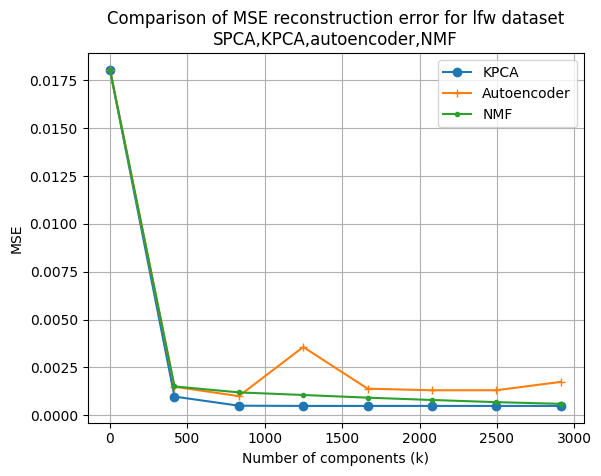

In [17]:
# Reload the test data which was just saved
fn_prefix="results_"
fn=fn_prefix+dataset_name+".p"
print("Filename:",fn)
res_loaded={}
with open(fn,"rb") as fp:
    res_loaded = pickle.load(fp)

k_spca,loss_spca=res_query(res_loaded,model="spca")
k_kpca,loss_kpca=res_query(res_loaded,model="kpca")
k_autoencoder,loss_autoencoder=res_query(res_loaded,model="autoencoder")
k_nmf,loss_nmf=res_query(res_loaded,model="nmf")

# Plot comparison
#plt.plot(k_spca,loss_spca,"x-")
plt.plot(k_kpca,loss_kpca,"o-")
plt.plot(k_autoencoder,loss_autoencoder,"+-")
plt.plot(k_nmf,loss_nmf,".-")
plt.grid('on')
plt.xlabel('Number of components (k)')
plt.ylabel('MSE')
plt.title('Comparison of MSE reconstruction error for '+dataset_name+' dataset\nSPCA,KPCA,autoencoder,NMF')
#plt.legend(["SPCA","KPCA","Autoencoder","NMF"])
plt.legend(["KPCA","Autoencoder","NMF"])